In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import warnings
from pandas import Grouper
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMAResults 

In [2]:
def get_data():
    return pd.read_csv('robberies.csv', index_col = 0, header = 0, squeeze = True, parse_dates = True)

In [3]:
series = get_data()
len(series)

118

# Validation Dataset

Last 12 months of data is kept for validation

In [4]:
split_point = len(series) - 12

dataset,validation = series[0:split_point], series[split_point:]
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """


In [5]:
print("Length of Dataset",len(dataset), sep = " : ")
print("Length of Validation",len(validation), sep =  " : ")

Length of Dataset : 106
Length of Validation : 12


# Model Evaluation

Model evaluation will only be performed on the data in dataset.csv

Test Strategy
Candidate models will be evaluated using walk-forward validation. This is because a rolling- forecast type model is required from the problem definition. This is where one-step forecasts are needed given all available data. The walk-forward validation will work as follows:
 - 1. The first 50% of the dataset will be held back to train the model.
 - 2. The remaining 50% of the dataset will be iterated and test the model. 
 - 3. For each step in the test dataset:
    - (a) A model will be trained.
    - (b) A one-step prediction made and the prediction stored for later evaluation.
    - (c) The actual observation from the test dataset will be added to the training dataset for the next iteration.
 - 4. The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

In [6]:
X = dataset.values
X = X.astype('float32')
train_split = int(len(X) * 0.5)

train, test = X[0:train_split], X[train_split:]

# Persistence Model

Walk Forward Validation

In [7]:
history = [x for x in train]
predictions = []
for t in range(len(test)):
    y_hat = history[-1]
    predictions.append(y_hat)
    observation = test[t]
    history.append(observation)
    print("Predicted Value", y_hat, "Actual Value", observation)
rmse = math.sqrt(mean_squared_error(test, predictions))
print("RMSE",rmse, sep = " : ")

Predicted Value 98.0 Actual Value 125.0
Predicted Value 125.0 Actual Value 155.0
Predicted Value 155.0 Actual Value 190.0
Predicted Value 190.0 Actual Value 236.0
Predicted Value 236.0 Actual Value 189.0
Predicted Value 189.0 Actual Value 174.0
Predicted Value 174.0 Actual Value 178.0
Predicted Value 178.0 Actual Value 136.0
Predicted Value 136.0 Actual Value 161.0
Predicted Value 161.0 Actual Value 171.0
Predicted Value 171.0 Actual Value 149.0
Predicted Value 149.0 Actual Value 184.0
Predicted Value 184.0 Actual Value 155.0
Predicted Value 155.0 Actual Value 276.0
Predicted Value 276.0 Actual Value 224.0
Predicted Value 224.0 Actual Value 213.0
Predicted Value 213.0 Actual Value 279.0
Predicted Value 279.0 Actual Value 268.0
Predicted Value 268.0 Actual Value 287.0
Predicted Value 287.0 Actual Value 238.0
Predicted Value 238.0 Actual Value 213.0
Predicted Value 213.0 Actual Value 257.0
Predicted Value 257.0 Actual Value 293.0
Predicted Value 293.0 Actual Value 212.0
Predicted Value 2

This means that on average, the model was wrong by about 51 robberies for each prediction made.

# Data Analysis

In [8]:
print(dataset.describe())

count    106.000000
mean     173.103774
std      112.231133
min       29.000000
25%       74.750000
50%      144.500000
75%      271.750000
max      487.000000
Name: Robberies, dtype: float64


### Line Plots : Visualizing Trend and Seasonality Patterns

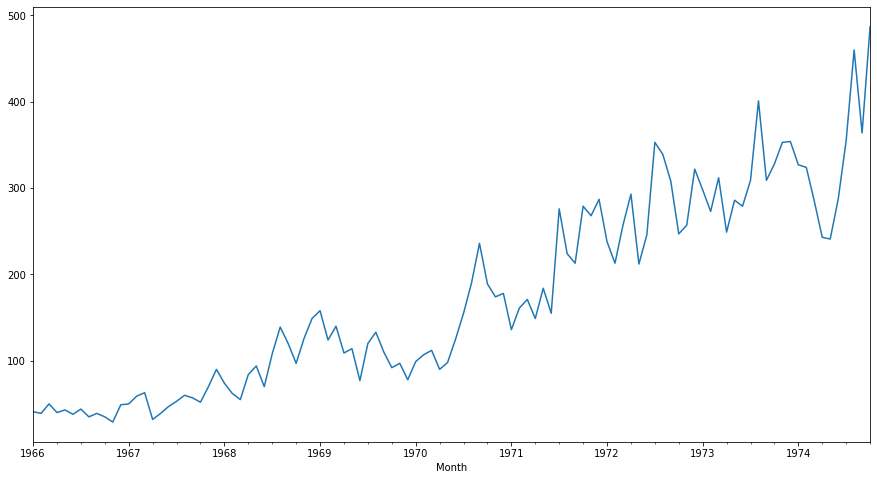

In [9]:
plt.figure(figsize = (15,8))
dataset.plot()
plt.show()

### Observations : 

 - There is an increasing Trend of robberies over time ( plot is going up )
 - Since we have a trend, we can assume that the dataset is not stationary
 - There seems to be large fluctuations in the number of robberies happening over time
 - The fluctuations seem to be low in the earlier years and then larger in the later years

### Density Plots :  Historgram and KDE

<Figure size 432x288 with 0 Axes>

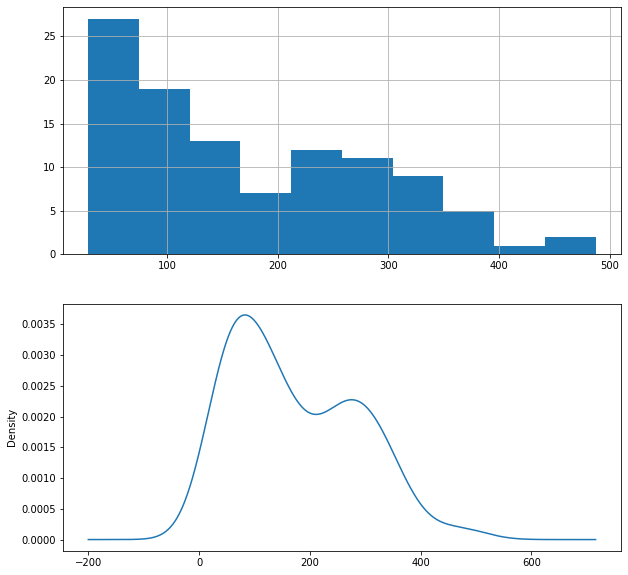

In [10]:
plt.figure(1)
plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
dataset.hist()
plt.subplot(2,1,2)
dataset.plot(kind = 'kde')
plt.show()

### Box & Whisker Plots

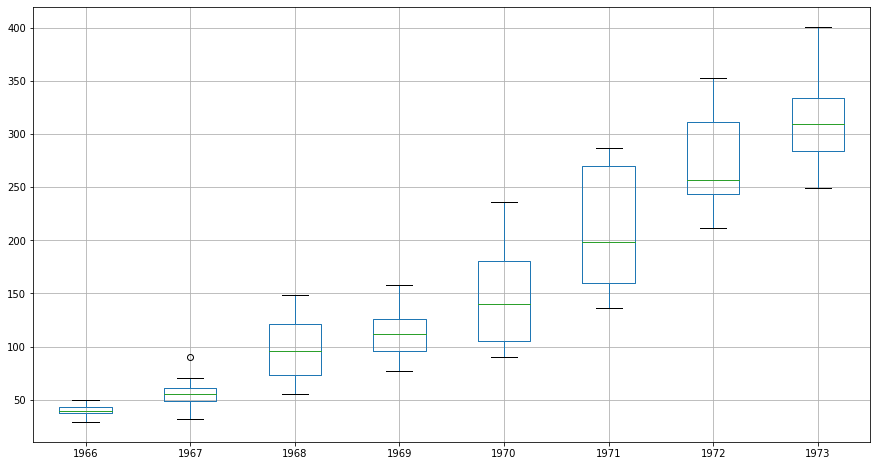

In [11]:
groups = dataset['1966':'1973'].groupby(Grouper(freq = 'A'))
years = pd.DataFrame()
for name,group in groups:
    years[name.year] = group.values
plt.figure(figsize = (15,8))    
years.boxplot()
plt.show()

### Observation

The boxplot for years 1966 and 1967 are different than the other years

We will develop Autoregressive Integrated Moving Average, or ARIMA, models for the problem. We will approach this in four steps:
 - 1. Developing a manually configured ARIMA model.
 - 2. Using a grid search of ARIMA to find an optimized model.
 - 3. Analysis of forecast residual errors to evaluate any bias in the model. 4. Explore improvements to the model using power transforms.

# ARIMA Models

In [12]:
def differencing(X):
    differenced = [X[i] - X[i-1] for i in range(1, len(X))]
    return pd.Series(differenced)

In [13]:
X = dataset.values
differenced_series = differencing(X)
differenced_series.index = dataset.index[1:]

### Checking for Stationary of the Differenced Series

In [14]:
result = adfuller(differenced_series)

In [15]:
print("ADF Statistic",result[0], sep = " : ")
print("p Value",result[1], sep = " : ")
for key,value in result[4].items():
    print(key,value,sep = " : ")

ADF Statistic : -3.9809463038611157
p Value : 0.0015136348242122454
1% : -3.502704609582561
5% : -2.8931578098779522
10% : -2.583636712914788


### Conclusion  :  

Since the ADF Statistic is less than the 5% significance level, we can thus reject the null hypothesis at this significance level thereby rejecting the claim that the series is non stationary ( i.e. it's statistics values have temporal structure in the data )

### Plot Auto-Correlation and Partial Auto-Correlation Plots

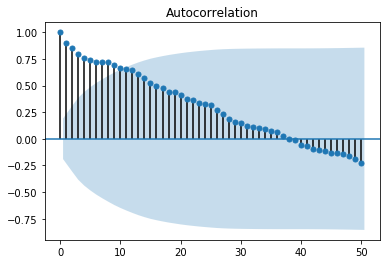

In [16]:
plot_acf(dataset, lags = 50)
plt.show()

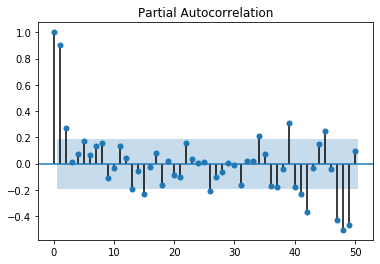

In [17]:
plot_pacf(dataset, lags = 50)
plt.show()

### Observation : 

The Autocorrelation plot shows that 10-11 lag variables in the autocorrelation plots shows significant correlation, whereas 2 lag varibles in the PACF plots show significant correlation

### Training A Manual Version of ARIMA Model

In [18]:
# history = [x for x in train]

# predictions = []

# for t in range(len(test)):
#     model  = ARIMA(history, order= (11,1,2))
#     model_fit = model.fit(disp = 0)
#     y_hat= model_fit.forecast()[0]
#     predictions.append(y_hat[0])
#     observation = test[t]
#     history.append(observation)
#     print("Predicted Value",y_hat[0], "Actual Value",observation)
# print("RMSE",math.sqrt(mean_squared_error(test, predictions)))    

###### The above configuration for ARIMA does not converge, so we change our starting point to ARIMA(0,1,2)

In [19]:
history = [x for x in train]

predictions = []

for t in range(len(test)):
    model  = ARIMA(history, order= (0,1,2))
    model_fit = model.fit(disp = 0)
    y_hat= model_fit.forecast()[0]
    predictions.append(y_hat[0])
    observation = test[t]
    history.append(observation)
    print("Predicted Value",y_hat[0], "Actual Value",observation)
print("RMSE",math.sqrt(mean_squared_error(test, predictions)))    

Predicted Value 102.70992212684135 Actual Value 125.0
Predicted Value 118.86819022574126 Actual Value 155.0
Predicted Value 141.09873757069067 Actual Value 190.0
Predicted Value 176.59269388450468 Actual Value 236.0
Predicted Value 233.41836832602195 Actual Value 189.0
Predicted Value 186.9054876265317 Actual Value 174.0
Predicted Value 184.84588616284702 Actual Value 178.0
Predicted Value 183.76322527188032 Actual Value 136.0
Predicted Value 146.17975451231646 Actual Value 161.0
Predicted Value 171.27868005129142 Actual Value 171.0
Predicted Value 170.1959863569491 Actual Value 149.0
Predicted Value 154.42480486627497 Actual Value 184.0
Predicted Value 185.70750590774048 Actual Value 155.0
Predicted Value 157.28370033896292 Actual Value 276.0
Predicted Value 245.28010783046355 Actual Value 224.0
Predicted Value 222.24230719017504 Actual Value 213.0
Predicted Value 219.6979396493055 Actual Value 279.0
Predicted Value 261.5064036142379 Actual Value 268.0
Predicted Value 264.287442299440

### Tuning ARIMA Hyperparameters -  Grid Search

In [20]:
def evaluate_arima(X, arima_order):
    X = X.values
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)
    train_set, test_set = X[0:train_size], X[train_size:]
    
    history = [x for x in train_set]
    predictions = []
    
    for t in range(len(test_set)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(disp = 0)
        y_hat = model_fit.forecast()[0]
        observation = test_set[t]
        predictions.append(y_hat[0])
        history.append(observation)
    rmse = math.sqrt(mean_squared_error(test_set, predictions))
    return rmse


In [21]:
def make_best_model(dataset, p_range, d_range, q_range):
    best_rmse,best_config = float("inf"), None
    dataset = dataset.astype('float32')
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    rmse = evaluate_arima(dataset, (p,d,q))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_config = (p,d,q)
                    else:
                        print("Model RMSE : ", rmse, "AT Config : ", (p,d,q))
                except:
                    continue
    print("Best RMSE", best_rmse, "Best Config", best_config)   

###### Always make sure to put the evaluate_arima model in the try block, as that code leads to non converge, so if a scenario happens when our model doesn't converge, then our try would handle that

In [22]:
p_range = range(0,13)
d_range = range(0,4)
q_range = range(0,13)
make_best_model(dataset, p_range, d_range, q_range)

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, 

Model RMSE :  80.80406111113604 AT Config :  (0, 2, 0)
Model RMSE :  52.45626633965887 AT Config :  (0, 2, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Model RMSE :  53.24277658875995 AT Config :  (1, 0, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encounte

Model RMSE :  50.58151975975906 AT Config :  (1, 1, 0)
Model RMSE :  68.67222177900791 AT Config :  (1, 2, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model RMSE :  52.031495701286005 AT Config :  (2, 0, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-maco

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessi

Model RMSE :  50.76055434187532 AT Config :  (2, 1, 0)
Model RMSE :  50.40719298022685 AT Config :  (2, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse

Model RMSE :  61.384316987419915 AT Config :  (2, 2, 0)
Model RMSE :  51.38764799611911 AT Config :  (2, 2, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Model RMSE :  52.234523718481306 AT Config :  (3, 0, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs 

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessi

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Model RMSE :  51.90065022528736 AT Config :  (3, 1, 0)
Model RMSE :  50.29514535366945 AT Config :  (3, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Model RMSE :  60.4107882219329 AT Config :  (3, 2, 0)
Model RMSE :  52.83025800271391 AT Config :  (3, 2, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWar

Model RMSE :  53.300104353328535 AT Config :  (4, 0, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anac

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:624: RuntimeWarning: invalid value encountered in true_divide
  newparams = np.tanh(params/2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:625: RuntimeWarning: invalid value encountered in true_divide
  tmp = np.tanh(params/2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/s

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to 

Model RMSE :  52.420494333396285 AT Config :  (4, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, 

Model RMSE :  52.2950881721516 AT Config :  (4, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params av

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization

Model RMSE :  56.286304325603545 AT Config :  (4, 2, 0)
Model RMSE :  53.206631140535904 AT Config :  (4, 2, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:624: RuntimeWarning: invalid value encountered in true_divide
  newparams = np.tanh(params/2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:625: RuntimeWarning: invalid value encountered in true_divide
  tmp = np.tanh(params/2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: Runtime

Model RMSE :  54.03625410869157 AT Config :  (5, 0, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:649: RuntimeWarning: invalid value encountered in double_scalars


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in subtract
  **kwargs)).imag/2./hess[i, j]
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available'

Model RMSE :  52.65293723221003 AT Config :  (5, 1, 0)
Model RMSE :  52.882547682589106 AT Config :  (5, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  '

Model RMSE :  57.37041133268686 AT Config :  (5, 2, 0)
Model RMSE :  53.203177454330735 AT Config :  (5, 2, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_ret

Model RMSE :  54.12254505683737 AT Config :  (6, 0, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-maco

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

Model RMSE :  52.43682304230931 AT Config :  (6, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Model RMSE :  51.488416754275924 AT Config :  (6, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse

Model RMSE :  58.30691248501755 AT Config :  (6, 2, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse

Model RMSE :  54.14458987066448 AT Config :  (7, 0, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:624: RuntimeWarning: invalid value encountered in true_divide
  newparams = np.tanh(params/2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:625: RuntimeWarning: invalid value encountered in true_divide
  tmp = np.tanh(params/2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/ts

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

Model RMSE :  51.104345467607985 AT Config :  (7, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Model RMSE :  52.34009134886066 AT Config :  (7, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: divide by zero encountered in arctanh
  invarcoefs = 2*np.arctanh(params)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:624: RuntimeWarning: invalid value encountered in true_divide
  newparams = np.tanh(params/2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:625: RuntimeWarning: invalid value encountered in true_divide
  tmp = np.tanh(params/2)
/Users/shekhartanwar/anaconda3/lib/pyt

Model RMSE :  53.080647352751186 AT Config :  (8, 0, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessi

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

Model RMSE :  51.75933732250504 AT Config :  (8, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_par

Model RMSE :  51.498475134004 AT Config :  (8, 1, 1)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to conver

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, 

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization

Model RMSE :  52.49117958160327 AT Config :  (9, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Users/shekhartanwar/anaconda3/

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, 

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1826: RuntimeWarning: invalid value encountered in sqrt
  fcerr = np.sqrt(np.cumsum(cumsum_n(ma_rep, self.k_diff)**2)*sigma2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, 

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in multiply
  **kwargs)).imag/2./hess[i, j]
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Ch

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

Model RMSE :  50.6610157021809 AT Config :  (10, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newp

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:693: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse o

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params avail

Model RMSE :  50.95959998770044 AT Config :  (11, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or c

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessi

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, 

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessi

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, 

Model RMSE :  51.162247289090004 AT Config :  (12, 1, 0)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  '

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, 

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to 

Best RMSE 49.82129273125429 Best Config (0, 1, 2)


/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [25]:
def evaluate_arima_best(X, arima_order):
    X = X.values
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)
    train_set, test_set = X[0:train_size], X[train_size:]
    
    history = [x for x in train_set]
    predictions = []
    
    for t in range(len(test_set)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(disp = 0)
        y_hat = model_fit.forecast()[0]
        observation = test_set[t]
        predictions.append(y_hat[0])
        history.append(observation)
    rmse = math.sqrt(mean_squared_error(test_set, predictions))
    residuals = [test_set[i] - predictions[i] for i in range(len(test_set))]
    return rmse, residuals



In [26]:
best_arima_order = (0,1,2)
rmse, residuals = evaluate_arima_best(dataset, best_arima_order)

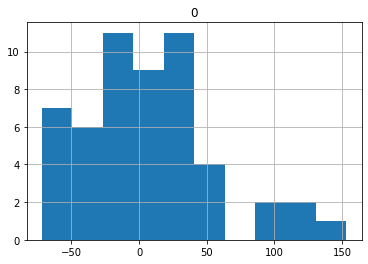

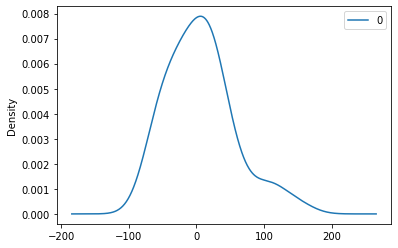

In [28]:
residuals = pd.DataFrame(residuals)
residuals.hist()
residuals.plot(kind = 'kde')
plt.show()

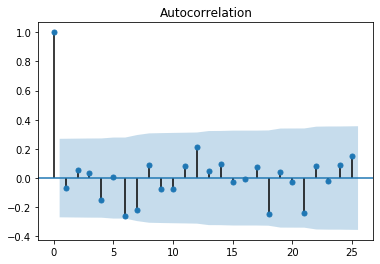

In [29]:
plot_acf(residuals, lags = 25)
plt.show()

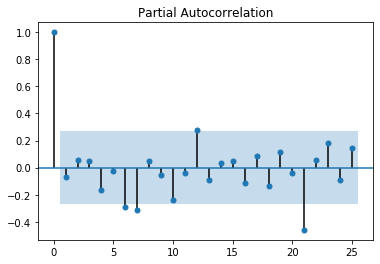

In [30]:
plot_pacf(residuals, lags = 25)
plt.show()

# Box Cox Transformation

Lambda : 0.26006033924618177


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c24139e80>]],
      dtype=object)

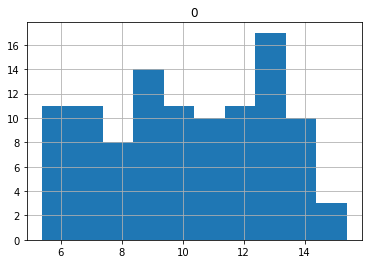

In [36]:
X = dataset.values
transformed, lam  = boxcox(X)
print("Lambda", lam, sep = " : ")
pd.DataFrame(transformed).hist()


### Observation :  The Histogram is not perfectly gaussian but better then previsous histogram which was skewed to the left

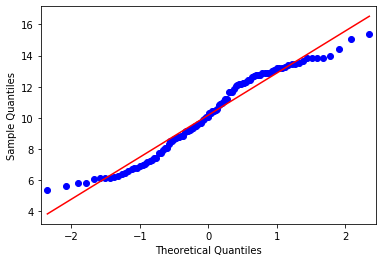

In [40]:
qqplot(transformed, line='r', ax=plt.gca()) 
plt.show()

### Observation :  The QQ Plot shows not a perfect gaussian distribution

transform = log(x), IF lambda = 0

transform = xlambda − 1 , IF lambda ̸= 0 lambda

This transform function can be reversed directly, as follows:

x = exp(transform), IF lambda = 0

x = exp(log(lambda × transform + 1)/lambda), IF lambda ̸= 0

In [48]:
def inverse_boxcox(lam, value):
    if lam == 0:
        return np.exp(value)
    else:
        return np.exp(np.log(lam * value + 1)/lam)


In [49]:
def evaluate_arima_best(X, arima_order):
    X = X.values
    X = X.astype('float32')
    train_size = int(len(X) * 0.5)
    train_set, test_set = X[0:train_size], X[train_size:]
    
    history = [x for x in train_set]
    predictions = []
    
    for t in range(len(test_set)):
        
        transformed, lam = boxcox(history)
        if lam < -5:
            transformed, lam = history, 1
        
        model = ARIMA(transformed, order = arima_order)
        model_fit = model.fit(disp = 0)
        y_hat = model_fit.forecast()[0]
        
        y_hat = inverse_boxcox(lam, y_hat)
        
        observation = test_set[t]
        predictions.append(y_hat[0])
        history.append(observation)
    rmse = math.sqrt(mean_squared_error(test_set, predictions))
    print("RMSE Transformed", rmse, sep = " : ")




In [50]:
evaluate_arima_best(dataset, (0,1,2))

/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/shekhartanwar/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


RMSE Transformed : 49.10278505050145


The Transformed dataset model is slightly better than the previous model without transform, so we will use this as the final model

# Model Validation

### Save Model

In [62]:
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__


X = dataset.values
transformed, lam = boxcox(X)

if lam < -5:
    transformed, lam = history,1

# Model Trained on the entire dataset    
model = ARIMA(transformed, (0,1,2))    
model_fit = model.fit(disp= 0)

model_fit.save('ARIMA_012.pkl')
np.save('lambda.npy',[lam])

### Loading the Model

In [59]:
model = ARIMAResults.load('ARIMA_012.pkl')
lam = np.load('lambda.npy')
y_hat = model.forecast()[0]
y_hat = inverse_boxcox(lam, y_hat)

### Validating the Model

In [78]:
X = dataset.values
X = X.astype('float32')
predictions,history= [],[]

history = [x for x in X]

valdiation = pd.read_csv('validation.csv', index_col = 0, header = 0, squeeze = True, parse_dates = True)
y = validation.values
y = y.astype('float32')
# we will make the first prediction, after the model has been completely trained on the dataset
# this first prediction would be the first value in the validation.csv

model = ARIMAResults.load('ARIMA_012.pkl')
lam = np.load('lambda.npy')
y_hat = model.forecast()[0]
y_hat = inverse_boxcox(lam, y_hat)

print("Predicted_Value", y_hat[0], "Actual Value", y[0])
predictions.append(y_hat)
history.append(y[0])

for t in range(1, len(y)):
    # we again transform the history before feeding it into the model
    transformed, lam = boxcox(history)
    if lam < -5:
        transformed, lam = history,1
        
    model = ARIMA(transformed, (0,1,2))
    model_fit = model.fit(disp = 0)
    y_hat = model_fit.forecast()[0]
    
    y_hat = inverse_boxcox(lam,y_hat)
    predictions.append(y_hat)
    observation = y[t]
    history.append(observation)
    
    print("Predictd Value", y_hat[0], "Actual Value", observation)



Predicted_Value 452.0368388746759 Actual Value 452.0
Predictd Value 423.09697471240366 Actual Value 391.0
Predictd Value 408.374595455765 Actual Value 500.0
Predictd Value 482.45594105266196 Actual Value 451.0
Predictd Value 445.94302049933924 Actual Value 375.0
Predictd Value 413.89350564092484 Actual Value 372.0
Predictd Value 413.2095565137985 Actual Value 302.0
Predictd Value 355.1570840702951 Actual Value 316.0
Predictd Value 363.51431633281123 Actual Value 398.0
Predictd Value 406.36234668583984 Actual Value 394.0
Predictd Value 394.1855040008174 Actual Value 431.0
Predictd Value 428.17485631494407 Actual Value 431.0


In [79]:
rmse = math.sqrt(mean_squared_error(y, predictions))    
print("RMSE", rmse, sep =  " : ")

RMSE : 53.07942738609104


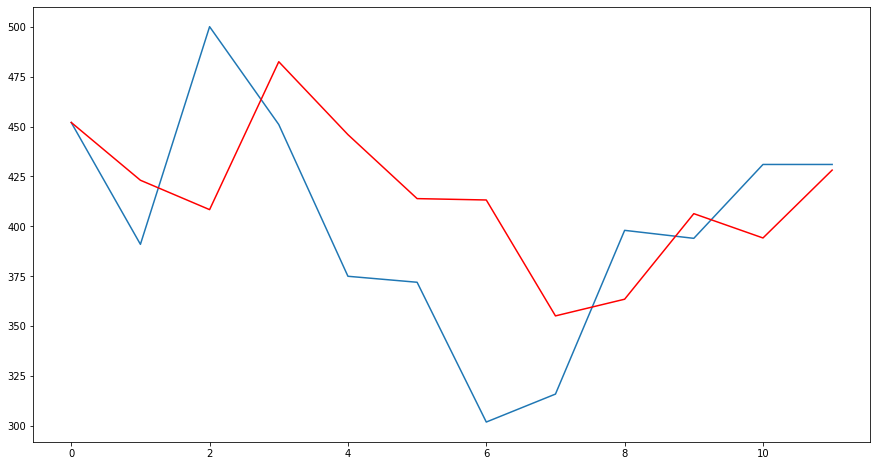

In [82]:
plt.figure(figsize = (15,8))
plt.plot(y)
plt.plot(predictions, color = 'red')
plt.show()

This Model's RMSE is equivalent to the Persistece Model's RMSE, therefore even after we chose the best ARIMA model, we couldn't get a better prediction score for the dataset